In [ ]:
#@ NECESSARY INSTALLATION
!pip install arcgis

In [ ]:
#@ NECESSARY IMPORTS
import pandas as pd
import zipfile,unicodedata
from itertools import repeat
from pathlib import Path
from arcgis.gis import GIS
# from arcgis.learn import prepare_textdata
# from arcgis.learn.text import EntityRecognizer
from arcgis.geocoding import batch_geocode
import re
import os
import datetime

In [ ]:
!pip install geopandas

In [ ]:
import pandas as pd
!pip install --upgrade pandas

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/master thesis on NLP/Colab Notebook/Dataset/disaster_data/dataset_015_to_024_bipad/Social Media Types/combined_articles - combined_articles.csv')
df = df[:10]
df

,sn,title,hazard,incident_on,province,district,municipality,ward,Unnamed: 8
0,0,"Landslide at Khabang Bagar , Putha Uttarganga ...",Landslide,7/16/2023,Lumbini,Rukum East,Putha Uttarganga,4,NaN
1,1,"Animal Incidents at Badkitaduwa, Barbardiya Mu...",Animal Incidents,7/16/2023,Lumbini,Bardiya,Barbardiya,7,NaN
2,2,"Landslide at Beshisahar, Nashong Rural Municip...",Landslide,7/16/2023,Gandaki,Manang,Nashong,3,NaN
3,3,Flood at Loghekar Damodarkunda Rural Municipal...,Flood,7/15/2023,Gandaki,Mustang,Loghekar Damodarkunda,5,NaN
4,4,"Landslide at Naini Bagar, Raghuganga Rural Mun...",Landslide,7/15/2023,Gandaki,Myagdi,Raghuganga,8,NaN
5,5,"Landslide at Ranikot, Putha Uttarganga Rural M...",Landslide,7/15/2023,Lumbini,Rukum East,Putha Uttarganga,4,NaN
6,6,"Landslide at Hiudekhola, Mathagadhi Rural Muni...",Landslide,7/15/2023,Lumbini,Palpa,Mathagadhi,1,NaN
7,7,"Fire at Rangeli Bazar, Rangeli Municipality-7",Fire,7/15/2023,Koshi,Morang,Rangeli,7,NaN
8,8,"Landslide at Janti Pahiro, Hupsekot Rural Muni...",Landslide,7/15/2023,Gandaki,Nawalparasi East,Hupsekot,4,NaN
9,9,"Landslide at Seto Pahare, Gaidakot Municipality-3",Landslide,7/15/2023,Gandaki,Nawalparasi East,Gaidakot,3,NaN


In [ ]:
# def geocode_locations(processed_df, district, province):
#     # Creating address with district and province
#     add_miner = processed_df.apply(lambda x: f'{x[district]}, {x[province]}', axis=1)
#     chunk_size = 200
#     chunks = (len(processed_df) // chunk_size) + 1
#     batch = []
#     for i in range(chunks):
#         batch.extend(batch_geocode(list(add_miner.iloc[chunk_size*i:chunk_size*(i+1)])))
#     batch_geo_codes = []
#     for i, item in enumerate(batch):
#         if isinstance(item, dict):
#             # Check if geocoding score is high and the returned address matches the district and province
#             if (item['score'] > 90 and
#                 item['attributes'].get('Province') == processed_df.iloc[i][province] and
#                 item['attributes'].get('District') == processed_df.iloc[i][district]):
#                 batch_geo_codes.append(item['location'])
#             else:
#                 batch_geo_codes.append('')
#         else:
#             batch_geo_codes.append('')
#     processed_df['geo_codes'] = batch_geo_codes
#     return processed_df


In [ ]:
# !pip install geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

def geocode_locations(processed_df, district, province):
    geolocator = Nominatim(user_agent="your_app_name")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    def get_location(row):
        address = f"{row[district]}, {row[province]}, Nepal"
        location = geocode(address)
        return (location.latitude, location.longitude) if location else (None, None)

    processed_df['latitude'], processed_df['longitude'] = zip(*processed_df.apply(get_location, axis=1))
    processed_df.dropna(subset=['latitude', 'longitude'], inplace=True)

    return processed_df

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# def prepare_gdf(processed_df):
#     # Initialize lists for longitude (x) and latitude (y) coordinates
#     longitudes = []
#     latitudes = []

#     # Iterate through the DataFrame to process each geocode
#     for geo_code in processed_df['geo_codes']:
#         if geo_code == '':
#             # Append None for missing geocodes
#             longitudes.append(None)
#             latitudes.append(None)
#         else:
#             # Extract x (longitude) and y (latitude) from the geocode and append to lists
#             longitudes.append(geo_code.get('x'))
#             latitudes.append(geo_code.get('y'))

#     # Add longitude and latitude as separate columns in the DataFrame
#     processed_df['longitude'] = longitudes
#     processed_df['latitude'] = latitudes

#     # Drop rows where geocode information is missing
#     processed_df.dropna(subset=['longitude', 'latitude'], inplace=True)

#     # Create GeoDataFrame using longitude and latitude
#     gdf = gpd.GeoDataFrame(processed_df, geometry=gpd.points_from_xy(processed_df.longitude, processed_df.latitude))

#     # Drop unnecessary columns
#     gdf.drop(['longitude', 'latitude', 'geo_codes'], axis=1, inplace=True)

#     return gdf
def prepare_gdf(processed_df):
    # Ensure rows with missing geocode information are already dropped
    processed_df.dropna(subset=['latitude', 'longitude'], inplace=True)

    # Create GeoDataFrame using latitude and longitude
    gdf = gpd.GeoDataFrame(processed_df, geometry=gpd.points_from_xy(processed_df.longitude, processed_df.latitude))

    return gdf

In [ ]:
import geopandas as gpd

def publish_to_feature(df, district, province, layer_title:str, tags:str):
    # Assuming geocode_locations and prepare_gdf are already defined and adapted to use district and province
    processed_df = geocode_locations(df, district, province)
    gdf = prepare_gdf(processed_df)

    # Exporting to GeoJSON
    geojson_file = f"{layer_title}.geojson"
    gdf.to_file(geojson_file, driver="GeoJSON")

    # Inform the user that the file is ready for upload
    print(f"GeoJSON file '{geojson_file}' is ready for upload.")

    # Return the path to the local GeoJSON file
    return geojson_file


In [ ]:
# Assuming your DataFrame is named 'df' and the relevant columns are named 'district' and 'province'
disaster_layer = publish_to_feature(df, 'district', 'province', 'disaster_data', 'disaster_management')


GeoJSON file 'disaster_data.geojson' is ready for upload.


In [ ]:
disaster_layer

'disaster_data.geojson'

In [ ]:
import base64
from IPython.display import HTML

def create_download_link(filename, title = "Download file"):
    with open(filename, 'rb') as f:
        data = f.read()
    b64 = base64.b64encode(data)
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# Use the function to create a download link for the geojson file
create_download_link(disaster_layer)


In [ ]:
import folium
import json

# Load your GeoJSON file
geojson_file = disaster_layer  # Replace with your file name
with open(geojson_file) as f:
    geojson_data = json.load(f)

# Coordinates for a central location in Nepal (e.g., Kathmandu)
latitude = 27.7172
longitude = 85.3240

# Create a map centered around the given coordinates
result_map = folium.Map(location=[latitude, longitude], zoom_start=7, tiles='OpenStreetMap')

# Add the GeoJSON layer with popups to the map
folium.GeoJson(
    geojson_data,
    name='geojson',
    style_function=lambda x: {'color':'blue', 'fillColor':'green', 'weight':2},
    tooltip=folium.GeoJsonTooltip(fields=['title', 'hazard', 'incident_on', 'province', 'district']),  # Adding province and district
    popup=folium.GeoJsonPopup(fields=['title', 'hazard', 'incident_on', 'province', 'district'])  # Adding province and district
).add_to(result_map)

# Add layer control to toggle the GeoJSON layer
folium.LayerControl().add_to(result_map)

# Display the map
result_map


In [ ]:
!pip install pysal

In [ ]:
import geopandas as gpd

gdf = gpd.read_file('/content/disaster_data.geojson')


<ipython-input-44-8e8e46dd379c>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf.groupby('province').apply(lambda x: x.plot(ax=ax, label=x.name))


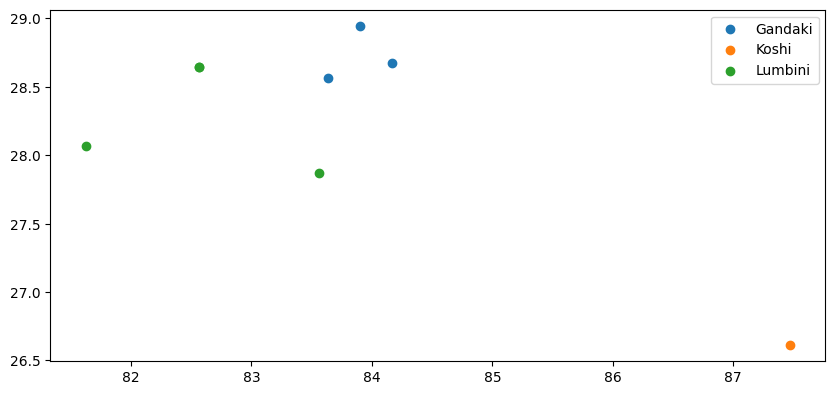

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your GeoDataFrame
gdf = gpd.read_file('/content/disaster_data.geojson')

# Ensure that the 'province' column is a string, not numerical
gdf['province'] = gdf['province'].astype(str)

# Plotting each province with a different color
fig, ax = plt.subplots(figsize=(10, 10))
gdf.groupby('province').apply(lambda x: x.plot(ax=ax, label=x.name))

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()


In [ ]:
import folium
import json

# Load your GeoJSON file
geojson_file = disaster_layer  # Replace with your file name
with open(geojson_file) as f:
    geojson_data = json.load(f)

# Define a color scheme for the provinces
province_colors = {
    'Koshi': 'blue',
    'Madhesh': 'green',
    'Bagmati': 'yellow',
    'Gandaki': 'brown',
    'Lumbini': 'purple',
    'Karnali': 'red',
    'Sudurpashchim': 'orange'
}

# Function to return the color for each feature
def style_function(feature):
    province = feature['properties']['province']
    color = province_colors.get(province, 'default_color')
    # print(f"Province: {province}, Color: {color}")
    return {
        'fillColor': province_colors.get(province, 'default_color'),
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.5
    }

# Coordinates for a central location in Nepal
latitude = 27.7172
longitude = 85.3240

# Create a map
result_map = folium.Map(location=[latitude, longitude], zoom_start=7, tiles='OpenStreetMap')

# Add the GeoJSON layer with styles
folium.GeoJson(
    geojson_data,
    style_function=style_function,
    name='geojson',
    tooltip=folium.GeoJsonTooltip(fields=['title', 'hazard', 'incident_on', 'province', 'district']),
    popup=folium.GeoJsonPopup(fields=['title', 'hazard', 'incident_on', 'province', 'district'])
).add_to(result_map)


# Add layer control
folium.LayerControl().add_to(result_map)

# Display the map
result_map
